# TODO

- you need plots


In [1]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare

from fixedeffect.fe import fixedeffect # for 3-way fixed https://pypi.org/project/FixedEffectModel/
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

import seaborn as sns

matplotlib.rcParams['font.family'] = 'serif'


In [2]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4.pkl', 'rb') as file:
    bodies_df = pickle.load(file)

In [3]:
bodies_df.shape

(152188, 194)

In [4]:
# if you only want more robust observatino:

bodies_df = bodies_df[(bodies_df['distance_days'] == 0) | (bodies_df['location_annot'] == 1)].copy() # only locations you are certain of
bodies_df = bodies_df[bodies_df['city'] != 'nan']

bodies_df = bodies_df[bodies_df['year'] >= 2003]
lwd = [294, 299, 300] # likely wrong dates/months. 
bodies_df = bodies_df[~bodies_df['month_id'].isin(lwd)].copy()


# indtil det er styr på det her:
bodies_df = bodies_df[bodies_df['publication'] != 'Published']

In [5]:
bodies_df.shape

(112343, 194)

In [6]:
#bodies_df[['Published', 'Raw', 'Submitted']] = pd.get_dummies(bodies_df[['publication']])
bodies_df[['Raw', 'Submitted']] = pd.get_dummies(bodies_df[['publication']])

bodies_df.drop(columns= 'publication', inplace= True)

# for FE
bodies_df.set_index(['gid', 'month_id'], inplace = True)
#bodies_df.set_index(['city_id', 'month_id'], inplace = True)



In [7]:
bodies_df['person_dummy'] = (bodies_df['person_mean'] > 0) * 1
bodies_df['female_dummy'] = (bodies_df['female_mean']> 0) * 1
bodies_df['male_dummy'] = (bodies_df['male_mean']> 0) * 1
bodies_df['firearm_dummy'] = (bodies_df['firearm_mean']> 0) * 1

bodies_df['firearm_log'] = np.log(bodies_df['firearm_mean'] + 1)
bodies_df['female_log'] = np.log(bodies_df['female_mean'] + 1)


bodies_df['emotions_mean'] = (bodies_df['emotions_t2_mean'] + bodies_df['emotions_t1_mean'])/2

bodies_df['religiousGarmentFemale_dummy'] = (bodies_df['religiousGarmentFemale_mean'] > 0) * 1


bodies_df['uniformed_dummy'] = (bodies_df['uniformed_mean'] > 0) * 1

bodies_df['mass_protest_top'] = (bodies_df['mass_protest_mean'] >= 1) * 1


### for plotting later

In [8]:
results_dict = {}

# NEW FTFP:

In [9]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['mass_protest_mean']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                Model Comparison                               
                               model1        model2        model3        model4
-------------------------------------------------------------------------------
Dep. Variable               Submitted     Submitted     Submitted     Submitted
Estimator                    PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations               112343        112343        112343        112343
Cov. Est.                      Robust     Clustered     Clustered     Clustered
R-squared                      0.0005        0.0008        0.0003        0.0008
R-Squared (Within)             0.0008        0.0008        0.0007        0.0008
R-Squared (Between)           -0.3958       -0.0079       -0.0050       -0.0085
R-Squared (Overall)            0.0005       -0.0045       -0.0027       -0.0049
F-statistic                    60.122        90.179        33.314        92.822
P-value (F-stat)               0.0000   

In [10]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['damaged_property_mean'] # but it is go with 'rural_mean'

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                 Model Comparison                                
                                 model1        model2        model3        model4
---------------------------------------------------------------------------------
Dep. Variable                 Submitted     Submitted     Submitted     Submitted
Estimator                      PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                 112343        112343        112343        112343
Cov. Est.                        Robust     Clustered     Clustered     Clustered
R-squared                        0.0006        0.0003        0.0003        0.0001
R-Squared (Within)               0.0003        0.0003        0.0003        0.0003
R-Squared (Between)             -0.3906        0.0050        0.0049        0.0029
R-Squared (Overall)              0.0006        0.0035        0.0034        0.0021
F-statistic                      67.760        38.591        34.918        11.786
P-value (F-stat)

In [11]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['uniformed_dummy'] # also not uniformed_mean

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                Model Comparison                               
                               model1        model2        model3        model4
-------------------------------------------------------------------------------
Dep. Variable               Submitted     Submitted     Submitted     Submitted
Estimator                    PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations               112343        112343        112343        112343
Cov. Est.                      Robust     Clustered     Clustered     Clustered
R-squared                   4.962e-07     2.214e-06     1.573e-06     1.265e-07
R-Squared (Within)           1.59e-06     2.214e-06     2.179e-06     9.629e-07
R-Squared (Between)           -0.3933       -0.0005       -0.0004       -0.0001
R-Squared (Overall)         4.962e-07       -0.0005       -0.0004       -0.0001
F-statistic                    0.0557        0.2487        0.1766        0.0142
P-value (F-stat)               0.8134   

In [12]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['militarized_mean'] # also not uniformed_mean

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                Model Comparison                                
                                model1        model2        model3        model4
--------------------------------------------------------------------------------
Dep. Variable                Submitted     Submitted     Submitted     Submitted
Estimator                     PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                112343        112343        112343        112343
Cov. Est.                       Robust     Clustered     Clustered     Clustered
R-squared                    1.688e-07     3.738e-05     1.081e-05        0.0001
R-Squared (Within)          -5.086e-06     3.738e-05     3.049e-05     5.738e-06
R-Squared (Between)            -0.3933       -0.0013       -0.0007       -0.0025
R-Squared (Overall)          1.688e-07       -0.0010       -0.0006       -0.0020
F-statistic                     0.0190        4.1983        1.2141        13.235
P-value (F-stat)            

In [13]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['log_best']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                Model Comparison                                
                                model1        model2        model3        model4
--------------------------------------------------------------------------------
Dep. Variable                Submitted     Submitted     Submitted     Submitted
Estimator                     PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                112343        112343        112343        112343
Cov. Est.                       Robust     Clustered     Clustered     Clustered
R-squared                       0.0002        0.0006        0.0016     2.708e-05
R-Squared (Within)             -0.0007        0.0006       -0.0067        0.0006
R-Squared (Between)            -0.3778        0.0036       -0.0105        0.0038
R-Squared (Overall)             0.0002        0.0190       -0.0914        0.0201
F-statistic                     25.587        65.840        185.22        3.0406
P-value (F-stat)            

In [14]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['firearm_dummy'] # firearm_mean is even better - propb not lienar but suggest taht up to some point more guns are better

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                Model Comparison                               
                               model1        model2        model3        model4
-------------------------------------------------------------------------------
Dep. Variable               Submitted     Submitted     Submitted     Submitted
Estimator                    PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations               112343        112343        112343        112343
Cov. Est.                      Robust     Clustered     Clustered     Clustered
R-squared                      0.0002        0.0002     8.782e-05        0.0002
R-Squared (Within)             0.0002        0.0002        0.0002        0.0002
R-Squared (Between)           -0.3926        0.0026        0.0019        0.0026
R-Squared (Overall)            0.0002        0.0020        0.0015        0.0020
F-statistic                    18.079        18.940        9.8633        17.866
P-value (F-stat)               0.0000   

In [15]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['female_mean']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                Model Comparison                                
                                model1        model2        model3        model4
--------------------------------------------------------------------------------
Dep. Variable                Submitted     Submitted     Submitted     Submitted
Estimator                     PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                112343        112343        112343        112343
Cov. Est.                       Robust     Clustered     Clustered     Clustered
R-squared                    2.023e-06     3.368e-05     9.369e-06        0.0001
R-Squared (Within)          -1.838e-05     3.368e-05     2.641e-05     1.319e-05
R-Squared (Between)            -0.3932        0.0014        0.0008        0.0025
R-Squared (Overall)          2.023e-06        0.0015        0.0008        0.0025
F-statistic                     0.2273        3.7830        1.0523        11.586
P-value (F-stat)            

In [16]:
feature = ['religiousGarmentFemale_dummy']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                     Model Comparison                                    
                                         model1        model2        model3        model4
-----------------------------------------------------------------------------------------
Dep. Variable                         Submitted     Submitted     Submitted     Submitted
Estimator                              PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                         112343        112343        112343        112343
Cov. Est.                                Robust     Clustered     Clustered     Clustered
R-squared                             8.029e-08     2.368e-05     7.155e-06     5.793e-05
R-Squared (Within)                   -2.848e-06     2.368e-05     1.898e-05     1.598e-05
R-Squared (Between)                     -0.3933        0.0010        0.0005        0.0015
R-Squared (Overall)                   8.029e-08        0.0008        0.0004        0.0012
F-statisti

In [17]:
feature = ['religiousGarmentFemale_dummy']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

                                     Model Comparison                                    
                                         model1        model2        model3        model4
-----------------------------------------------------------------------------------------
Dep. Variable                         Submitted     Submitted     Submitted     Submitted
Estimator                              PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                         112343        112343        112343        112343
Cov. Est.                                Robust     Clustered     Clustered     Clustered
R-squared                             8.029e-08     2.368e-05     7.155e-06     5.793e-05
R-Squared (Within)                   -2.848e-06     2.368e-05     1.898e-05     1.598e-05
R-Squared (Between)                     -0.3933        0.0010        0.0005        0.0015
R-Squared (Overall)                   8.029e-08        0.0008        0.0004        0.0012
F-statisti

## initial conclution:

Sanitiszing war:
- Nothing from log_best
- Nothing from uniformes
- militarized Nothing from 
- Something from protest
- Something from destroyed property - when controling for rural
- Something from fiarm


# Gender
- Somthing from Garments
- Something from female


### Sanitizing war:

### Log_best

In [18]:

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'mass_protest_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'mass_protest_mean', 'damaged_property_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'mass_protest_mean', 'damaged_property_mean', 'uniformed_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'mass_protest_mean', 'damaged_property_mean', 'uniformed_mean', 'firearm_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'mass_protest_mean', 'damaged_property_mean', 'uniformed_mean', 'firearm_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                               Model Comparison                                              
                                 model1        model2        model3        model4        model5        model6
-------------------------------------------------------------------------------------------------------------
Dep. Variable                 Submitted     Submitted     Submitted     Submitted     Submitted     Submitted
Estimator                      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                 112343        112343        112343        112343        112343        112343
Cov. Est.                     Clustered     Clustered     Clustered     Clustered     Clustered     Clustered
R-squared                     2.708e-05        0.0009        0.0009        0.0009        0.0011        0.0015
R-Squared (Within)               0.0006        0.0012        0.0013        0.0014        0.0016       -0.0517
R-Squared 

In [19]:
results_dict['log_best'] = [0.0047, 0.0334]

### Uniforms

In [20]:

X = bodies_df.loc[:,['uniformed_dummy']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'uniformed_dummy', 'person_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'uniformed_dummy', 'person_mean', 'firearm_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'uniformed_dummy', 'person_mean', 'firearm_dummy', 'log_best']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'uniformed_dummy', 'person_mean', 'firearm_dummy', 'log_best', 'damaged_property_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'uniformed_dummy', 'person_mean', 'firearm_dummy', 'log_best', 'damaged_property_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                Model Comparison                                               
                                 model1        model2        model3        model4         model5         model6
---------------------------------------------------------------------------------------------------------------
Dep. Variable                 Submitted     Submitted     Submitted     Submitted      Submitted      Submitted
Estimator                      PanelOLS      PanelOLS      PanelOLS      PanelOLS       PanelOLS       PanelOLS
No. Observations                 112343        112343        112343        112343         112343         112343
Cov. Est.                     Clustered     Clustered     Clustered     Clustered      Clustered      Clustered
R-squared                     1.265e-07       2.9e-06        0.0002        0.0002         0.0003         0.0007
R-Squared (Within)            9.629e-07     1.432e-05        0.0002        0.0008         0.0011        

In [21]:
results_dict['uniformed'] = [-0.0027, 0.0038]

### Protest:

In [35]:

X = bodies_df.loc[:,['mass_protest_mean']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'mass_protest_mean', 'person_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'mass_protest_mean', 'person_mean', 'public_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'mass_protest_mean', 'person_mean', 'public_mean', 'log_best']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'mass_protest_mean', 'person_mean', 'public_mean', 'log_best', 'urban_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'mass_protest_mean', 'person_mean', 'public_mean', 'log_best', 'urban_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                Model Comparison                                               
                               model1        model2         model3         model4         model5         model6
---------------------------------------------------------------------------------------------------------------
Dep. Variable               Submitted     Submitted      Submitted      Submitted      Submitted      Submitted
Estimator                    PanelOLS      PanelOLS       PanelOLS       PanelOLS       PanelOLS       PanelOLS
No. Observations               112343        112343         112343         112343         112343         112343
Cov. Est.                   Clustered     Clustered      Clustered      Clustered      Clustered      Clustered
R-squared                      0.0008        0.0010         0.0016         0.0016         0.0016         0.0021
R-Squared (Within)             0.0008        0.0011         0.0018         0.0022         0.0023        

In [23]:
results_dict['protest'] = [0.0457, 0.0036]

So a 6% point increae in the probabilty of submission of you are over the 65% percential in protest. robustly.

### Damaged property

In [24]:

X = bodies_df.loc[:,['damaged_property_mean']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'damaged_property_mean', 'rural_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'damaged_property_mean', 'rural_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'damaged_property_mean', 'rural_mean', 'nlights_mean', 'log_best']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'damaged_property_mean', 'rural_mean', 'nlights_mean', 'log_best', 'person_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'damaged_property_mean', 'rural_mean', 'nlights_mean', 'log_best', 'person_mean', 'militarized_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                               Model Comparison                                               
                                 model1        model2        model3        model4        model5         model6
--------------------------------------------------------------------------------------------------------------
Dep. Variable                 Submitted     Submitted     Submitted     Submitted     Submitted      Submitted
Estimator                      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS       PanelOLS
No. Observations                 112343        112343        112343        112343        112343         112343
Cov. Est.                     Clustered     Clustered     Clustered     Clustered     Clustered      Clustered
R-squared                        0.0001        0.0004        0.0015        0.0020        0.0020         0.0025
R-Squared (Within)               0.0003        0.0006       -0.1759       -0.2862       -0.2871        -0.3211
R

1.5% point increase for the top 65% with damaged property

In [25]:
results_dict['damaged'] = [0.0146, 0.0057]

## GUNS

In [26]:

X = bodies_df.loc[:,['firearm_log']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'firearm_log', 'uniformed_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'firearm_log', 'uniformed_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'firearm_log', 'uniformed_mean', 'nlights_calib_mean', 'log_best']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'firearm_log', 'uniformed_mean', 'nlights_calib_mean', 'log_best', 'damaged_property_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'firearm_log', 'uniformed_mean', 'nlights_calib_mean', 'log_best', 'damaged_property_mean', 'mass_protest_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                               Model Comparison                                              
                                 model1        model2        model3        model4        model5        model6
-------------------------------------------------------------------------------------------------------------
Dep. Variable                 Submitted     Submitted     Submitted     Submitted     Submitted     Submitted
Estimator                      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                 112343        112343        112343        112343        112343        112343
Cov. Est.                     Clustered     Clustered     Clustered     Clustered     Clustered     Clustered
R-squared                        0.0002        0.0003        0.0007        0.0007        0.0008        0.0015
R-Squared (Within)               0.0003        0.0003       -0.0543       -0.0574       -0.0560       -0.0516
R-Squared 

In [27]:
results_dict['firearm_log'] = [0.0185, 0.0068]

so 1% increse in the probability of submission for each gun - lilke not lenar one or more guns
log (make sense with deminising effect) 2% increase in the probabilty of submission each time the numbe of guns ... check woolridge!

# Gender
## Female

In [28]:

X = bodies_df.loc[:,['female_dummy']]
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_mean', 'nlights_calib_mean', 'log_best']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_mean', 'nlights_calib_mean', 'log_best', 'religiousGarmentFemale_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_mean', 'nlights_calib_mean', 'log_best', 'religiousGarmentFemale_dummy', 'privat_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                  Model Comparison                                                  
                                        model1        model2        model3        model4        model5        model6
--------------------------------------------------------------------------------------------------------------------
Dep. Variable                        Submitted     Submitted     Submitted     Submitted     Submitted     Submitted
Estimator                             PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                        112343        112343        112343        112343        112343        112343
Cov. Est.                            Clustered     Clustered     Clustered     Clustered     Clustered     Clustered
R-squared                            2.991e-05     4.748e-05        0.0005        0.0005        0.0006        0.0006
R-Squared (Within)                   -1.46e-05     1.926e-05    

In [29]:
results_dict['female_dummy'] = [0.0018, 0.0022]

So there might be something, but it is not near substantially irrellevant..

## Garments

In [30]:

X = bodies_df.loc[:,['religiousGarmentFemale_dummy']]
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'religiousGarmentFemale_dummy', 'female_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'religiousGarmentFemale_dummy', 'female_dummy', 'log_best']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'religiousGarmentFemale_dummy', 'female_dummy', 'log_best', 'rural_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'religiousGarmentFemale_dummy', 'female_dummy', 'log_best', 'rural_mean', 'mass_protest_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'religiousGarmentFemale_dummy', 'female_dummy', 'log_best', 'rural_mean', 'mass_protest_mean', 'nlights_calib_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

                                                  Model Comparison                                                  
                                        model1        model2        model3        model4        model5        model6
--------------------------------------------------------------------------------------------------------------------
Dep. Variable                        Submitted     Submitted     Submitted     Submitted     Submitted     Submitted
Estimator                             PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS      PanelOLS
No. Observations                        112343        112343        112343        112343        112343        112343
Cov. Est.                            Clustered     Clustered     Clustered     Clustered     Clustered     Clustered
R-squared                            5.793e-05     6.461e-05     9.203e-05       9.3e-05        0.0009        0.0013
R-Squared (Within)                   1.598e-05     5.354e-06    

In [31]:
results_dict['garments_dummy'] = [0.0028, 0.0015]

# PLOT

In [32]:
for i,j in enumerate(results_dict.keys()):
    print(i,j)

0 log_best
1 uniformed
2 protest
3 damaged
4 firearm_log
5 female_dummy
6 garments_dummy


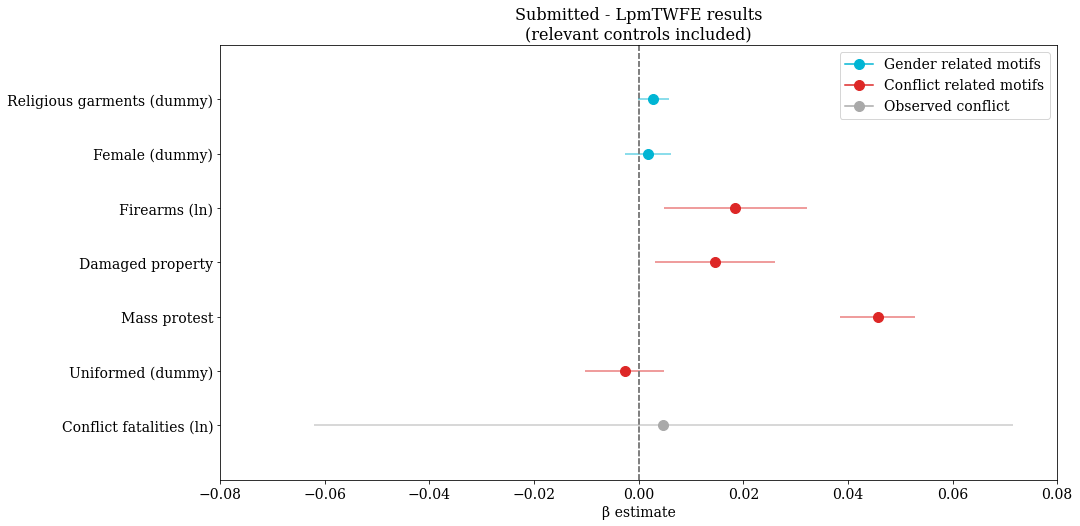

In [33]:
plt.figure(figsize = [15,8])

yticks = []
#yticks_l = []
yticks_l = ['Conflict fatalities (ln)', 'Uniformed (dummy)', 'Mass protest', 'Damaged property', 'Firearms (ln)', 'Female (dummy)', 'Religious garments (dummy)']



for i,j in enumerate(results_dict.keys()):

    if j in ['female_dummy', 'garments_dummy']:
        color = '#00b5d4'

    elif j == 'log_best':
        color = 'darkgray'

    else:
        color = '#dd2726'

    plt.scatter(results_dict[j][0], i+1, color = color, s = 100)

    plt.errorbar(results_dict[j][0], i+1, xerr = results_dict[j][1]*2, color = color, alpha = 0.6)
    plt.vlines(0,0,10, linestyle = 'dashed', color = 'gray', alpha = 0.6)

    yticks.append(i+1)
    #yticks_l.append(j)

plt.title('Submitted - LpmTWFE results\n(relevant controls included)', fontsize = 16)

plt.xticks(fontsize = 14)
plt.yticks(yticks, yticks_l, fontsize = 14)
plt.ylim(0, max(yticks) +1 )
plt.xlim(-0.08, 0.08)
plt.xlabel('β estimate', fontsize = 14)

gen_cap = mlines.Line2D([], [], color='#00b5d4', marker='o', markersize=10, label='Gender related motifs')
mil_cap = mlines.Line2D([], [], color='#dd2726', marker='o', markersize=10, label='Conflict related motifs')
leg_cap = mlines.Line2D([], [], color='darkgray', marker='o', markersize=10, label='Observed conflict')

plt.legend(handles=[gen_cap, mil_cap, leg_cap], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/frontline/results0.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [ ]:
results_dict

# Robustness:

In [ ]:
['best (ln)', 'uniformed (dummy)', 'mass protest', 'damaged property', 'firearms (ln)', 'female (dummy)', 'religious garments (dummy)']

In [ ]:
yticks_l

In [ ]:
for i in bodies_df.columns:
    print(i)

#  OLD:

# Introducing ....

nlights_calib_mean',
       'nlights_mean', 'pasture_ih', 'petroleum_y', 'pop_gpw_sd',
       'pop_gpw_sum', 

### uniformed

In [ ]:
# POOLD

X = bodies_df.loc[:,['log_best']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model2 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model3 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model4 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model5 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model6 = m.fit(cov_type='robust')

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# FE Entity

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# FE TIME

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# TWO-WAY FE

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'damaged_property_mean', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'uniformed_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
#Baghdad gid = 177569
baghdad_df = bodies_df.loc[[177569]].copy()
baghdad_df['damaged_property_clip'] = np.clip(baghdad_df['damaged_property_mean'], 0, None)

In [ ]:
#feature = ['damaged_property_mean', 'rural_mean']
# 'rural_mean', 'log_best', 'person_mean'

feature = ['uniformed_dummy']
target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,['log_best']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,['tce']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='robust')


X = bodies_df.loc[:,['tsce']]
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model3 =  m.fit(cov_type='robust')



print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

In [ ]:
feature_list = ['person_dummy','female_dummy','male_dummy','religiousGarmentFemale_dummy',
                'uniformed_dummy','mass_protest_mean','emotions_t2_mean','formal_mean',
                'privat_mean','urban_mean','militarized_mean','damaged_property_mean',
                'public_mean','emotions_t1_mean']

In [ ]:
for feature in feature_list:

    target =  'Submitted' #'uniformed_dummy'

    X = bodies_df.loc[:,feature] 
    X = sm.add_constant(X)
    y = bodies_df.loc[:, target]

    m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
    model1 =  m.fit(cov_type='robust')

    X = bodies_df.loc[:,feature] 
    #X = sm.add_constant(X)
    y = bodies_df.loc[:, target]

    m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
    model2 =  m.fit(cov_type='clustered', cluster_entity=True)


    X = bodies_df.loc[:,feature] 
    #X = sm.add_constant(X)
    y = bodies_df.loc[:, target]

    m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
    model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


    X = bodies_df.loc[:,feature] 
    #X = sm.add_constant(X)
    y = bodies_df.loc[:, target]

    m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
    model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


    print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

# NEW THING FOR INTRODUCTION TO

In [ ]:
#feature = ['damaged_property_mean', 'rural_mean']

feature = ['mass_protest_mean']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=False, cluster_time = True)


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

In [ ]:
feature = ['mass_protest_mean']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)

X = bodies_df.loc[:,feature + ['person_mean']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)

X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)

X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'tce']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)


X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'tsce']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
feature = ['mass_protest_mean']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = False)

X = bodies_df.loc[:,feature + ['person_mean']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = False)

X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = False)

X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = False)


X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'log_best', 'rural_mean']] #"!!!!!!"
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = False)


X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'tsce']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model6 =  m.fit(cov_type='clustered', cluster_entity=True,  cluster_time = False)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
feature = ['mass_protest_mean']

target =  'Submitted' #'uniformed_dummy'


X = bodies_df.loc[:,feature] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature + ['person_mean']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model2 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model3 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'log_best']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model4 =  m.fit(cov_type='robust')


X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'tce']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model5 =  m.fit(cov_type='robust')


X = bodies_df.loc[:,feature+ ['person_mean', 'public_mean', 'tsce']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, target]

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model6 =  m.fit(cov_type='robust')

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# POOLD

X = bodies_df.loc[:,['uniformed_dummy']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, 'log_best']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model2 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model3 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model4 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model5 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model6 = m.fit(cov_type='robust')

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

## Destroyd property 

In [ ]:
# POOLD

X = bodies_df.loc[:,['log_best']] 
X = sm.add_constant(X)
y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model2 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model3 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model4 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model5 = m.fit(cov_type='robust')

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=False, drop_absorbed = True)
model6 = m.fit(cov_type='robust')

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# FE Entity

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=False, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=False, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# FE TIME

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=False, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=False)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
# TWO-WAY FE

X = bodies_df.loc[:,['log_best']] 
#X = sm.add_constant(X)
y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'log_best', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'tce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'tsce', 'person_dummy', 'uniformed_dummy', 'nlights_mean']] 
#X = sm.add_constant(X)

y = bodies_df.loc[:, 'damaged_property_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

# 1.3

## FTFP female

In [ ]:
#FEMALE
X = bodies_df.loc[:,['female_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy','all_privat_mean', 'all_rural_mean','nlights_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean','nlights_mean', 'log_best']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy','all_privat_mean', 'all_rural_mean','nlights_mean', 'tce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model7 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean','nlights_mean', 'tsce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model8 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6, "model7": model7, "model8": model8}, precision = 'std_errors', stars = True))

# FLFP GAR

In [ ]:
# GARMENTS
X = bodies_df.loc[:,['religiousGarmentFemale_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy', 'all_privat_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean','nlights_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean','nlights_mean', 'log_best']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model7 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean','nlights_mean', 'tce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model8 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['religiousGarmentFemale_dummy', 'female_dummy', 'person_dummy', 'all_privat_mean', 'all_rural_mean','nlights_mean', 'tsce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model9 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6, "model7": model7, "model8": model8, "model9": model9}, precision = 'std_errors', stars = True))

# FTFP damaged

In [ ]:
X = bodies_df.loc[:,['damaged_property_mean' ]] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['damaged_property_mean', 'all_rural_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['damaged_property_mean', 'all_rural_mean', 'all_militarized_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['damaged_property_mean', 'all_rural_mean', 'all_militarized_mean', 'nlights_mean',  'log_best']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['damaged_property_mean', 'all_rural_mean', 'all_militarized_mean', 'nlights_mean',  'tce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['damaged_property_mean', 'all_rural_mean', 'all_militarized_mean', 'nlights_mean',  'tsce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

# FTPT Protest

In [ ]:
X = bodies_df.loc[:,['mass_protest_mean' ]] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['mass_protest_mean', 'person_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['mass_protest_mean', 'person_mean', 'all_public_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['mass_protest_mean', 'person_mean', 'all_public_mean', 'all_urban_mean',  'log_best']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['mass_protest_mean', 'person_mean', 'all_public_mean', 'all_urban_mean',  'tce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['mass_protest_mean', 'person_mean', 'all_public_mean', 'all_urban_mean',  'tsce']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

# FTPT EMOTION

In [ ]:
X = bodies_df.loc[:,['emotions_t1_mean' ]] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy' ]] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'mass_protest_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model3": model5, "model5": model5 }, precision = 'std_errors', stars = True))

# What is emotion made of?

In [ ]:
X = bodies_df.loc[:,['person_dummy']] 
y = bodies_df.loc[:, 'emotions_t1_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['person_dummy', 'female_dummy']] 
y = bodies_df.loc[:, 'emotions_t1_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = bodies_df.loc[:,['person_dummy',  'female_dummy', 'religiousGarmentFemale_dummy']] 
y = bodies_df.loc[:, 'emotions_t1_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['person_dummy',  'female_dummy', 'religiousGarmentFemale_dummy', 'mass_protest_mean']] 
y = bodies_df.loc[:, 'emotions_t1_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['person_dummy',  'female_dummy', 'religiousGarmentFemale_dummy', 'mass_protest_mean', 'all_militarized_mean']] 
y = bodies_df.loc[:, 'emotions_t1_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4, "model5" : model5}, precision = 'std_errors', stars = True))

In [ ]:
bodies_df.columns

# Violence

In [ ]:
# GARMENTS
X = bodies_df.loc[:,['log_best']] 
y = bodies_df.loc[:, 'female_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['log_best', 'person_dummy']] 
y = bodies_df.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['log_best', 'religiousGarmentFemale_dummy', 'person_dummy']] 
y = bodies_df.loc[:, 'female_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

In [ ]:
# GARMENTS
X = bodies_df.loc[:,['log_best']] 
y = bodies_df.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['log_best', 'female_dummy']] 
y = bodies_df.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = bodies_df.loc[:,['log_best', 'female_dummy', 'person_dummy']] 
y = bodies_df.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

# old

In [ ]:
#E2
X = bodies_df.loc[:,['emotions_t1_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


#E2
X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


#E2
X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy', 'female_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


#E2
X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


#E2
X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy',  'uniformed_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


#E2
X = bodies_df.loc[:,['emotions_t1_mean', 'person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy',  'uniformed_mean', 'all_militarized_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "mode6": model6}, precision = 'std_errors', stars = True))

In [ ]:
#E2
X = bodies_df.loc[:,['emotions_t1_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


#E2
X = bodies_df.loc[:,['emotions_t2_mean', 'emotions_t1_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2}, precision = 'std_errors', stars = True))

In [ ]:
#FEMALE
X = bodies_df.loc[:,['damaged_property_mean']] 
y = bodies_df.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



In [ ]:
ra = ['damaged_property_mean', 'militaryVehicle_mean', 'firearm_mean', 'flagUS_mean', 'uniformed_mean', 'all_militarized_mean', 'emotions_t2_mean', 'emotions_t1_mean']

for i in ra:

    X = bodies_df.loc[:,[i]] 
    y = bodies_df.loc[:, 'Submitted']

    m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
    model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

    print(model1)

In [ ]:
mass_protest_mean

In [ ]:
bodies_df.columns

# Summary: FFTF

In [ ]:

X = df_sub.loc[:,['female_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4}, precision = 'std_errors', stars = True))

# JACOB STRUCTURE:


In [ ]:
#FEMALE
X = df_sub.loc[:,['female_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'person_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat', 'all_rural']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean', 'log_best']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean', 'tce']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model7 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean', 'tsce']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model8 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6, "model7": model7, "model8": model8}, precision = 'std_errors', stars = True))

In [ ]:
# GARMENTS
X = df_sub.loc[:,['religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy', 'all_privat']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy', 'all_privat', 'all_rural']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean', 'log_best']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model7 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean', 'tce']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model8 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy', 'person_dummy', 'all_privat', 'all_rural','nlights_mean', 'tsce']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model9 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4, "model5": model5, "model6": model6, "model7": model7, "model8": model8, "model9": model9}, precision = 'std_errors', stars = True))

In [ ]:
df_sub[df_sub['female_dummy'] == 1].shape[0] / df_sub.shape[0]

In [ ]:
df_sub[(df_sub['female_dummy'] == 1)&(df_sub['Submitted'] == 1)].shape[0] / df_sub[df_sub['Submitted'] == 1].shape[0]

In [ ]:
df_sub[df_sub['Submitted'] == 1].shape[0]

In [ ]:
df_sub[(df_sub['religiousGarmentFemale_dummy'] == 1)&(df_sub['Submitted'] == 1)].shape[0]

In [ ]:

X = df_sub.loc[:,['tce']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['tce', 'log_best']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['tce', 'log_best', 'nlights_mean']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

In [ ]:

X = df_sub.loc[:,['tsce']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['tsce', 'log_best']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['tsce', 'log_best', 'nlights_mean']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3}, precision = 'std_errors', stars = True))

In [ ]:
sns.heatmap(df_sub.loc[:,['tce','tsce', 'log_best', 'nlights_mean']].corr(), cmap= 'Reds' , annot=True)
plt.show()

# Summary: VVV

In [ ]:
#'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed', 'nlights_mean_observed', 
df_sub['llights'] = np.log(df_sub['nlights_calib_mean'])

# X = df_sub.loc[:,['log_best']] 
# y = df_sub.loc[:, 'religiousGarmentFemale_mean']

# m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
# model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['log_best', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['log_best', 'female_mean', 'all_public']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['log_best', 'female_mean', 'all_privat']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['log_best', 'female_mean', 'all_public', 'all_privat']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['log_best', 'female_mean', 'all_public', 'all_privat', 'uniformed_dummy']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['log_best', 'female_mean', 'all_public', 'all_privat', 'uniformed_dummy', 'nlights_calib_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3,  "model4": model4, "model5": model5, "model6": model6}, precision = 'std_errors', stars = True))

In [ ]:
#'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed', 'nlights_mean_observed', 

df_sub['llights'] = np.log(df_sub['nlights_calib_mean'])
#df_sub1 = df_sub[df_sub['person_mean'] != 0] # no people, no entry

X = df_sub1.loc[:,['log_best']] 
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub1.loc[:,['log_best', 'all_public']] 
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural']] 
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural', 'llights']] 
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural', 'llights', 'Submitted']] 
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural', 'llights', 'Submitted', 'uniformed_mean']] 
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4, "model4" : model5, "model4" : model6}, precision = 'std_errors', stars = True))

In [ ]:
#'nlights_calib_mean', 'nlights_mean', 'nlights_calib_mean_observed', 'nlights_mean_observed', 

df_sub['llights'] = np.log(df_sub['nlights_calib_mean'])
df_sub1 = df_sub[df_sub['person_mean'] != 0] # no people, no entry



X = df_sub1.loc[:,['log_best']] 
X = sm.add_constant(X)
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub1.loc[:,['log_best', 'all_public']]
X = sm.add_constant(X)
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural']] 
X = sm.add_constant(X)
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural', 'llights']] 
X = sm.add_constant(X)
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural', 'llights', 'Submitted']] 
X = sm.add_constant(X)
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub1.loc[:,['log_best', 'all_public', 'all_rural', 'llights', 'Submitted', 'uniformed_mean']] 
X = sm.add_constant(X)
y = df_sub1.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4, "model4" : model5, "model4" : model6}, precision = 'std_errors', stars = True))

In [ ]:
PanelOLS?

In [ ]:
df_sub2 = df_sub.reset_index()

In [ ]:
exog_x = ['log_best']
y = ['religiousGarmentFemale_mean']

category = ['gid', 'month_id', 'female_mean']
cluster =  ['gid', 'month_id', 'female_mean']


model_fe = fixedeffect(data_df = df_sub2,
                      dependent = y,
                      exog_x = exog_x,
                      category = category,
                      cluster = cluster)

result = model_fe.fit()
result.summary()

In [ ]:
fixedeffect?

In [ ]:
X = df_sub.loc[:,['log_best', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['log_best', 'all_public', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



X = df_sub.loc[:,['log_best', 'all_public', 'all_rural', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



X = df_sub.loc[:,['log_best', 'all_public', 'all_rural', 'nlights_mean', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



X = df_sub.loc[:,['log_best', 'all_public', 'all_rural', 'nlights_mean', 'Submitted', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model5 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



X = df_sub.loc[:,['log_best', 'all_public', 'all_rural', 'nlights_mean', 'Submitted', 'uniformed_mean', 'female_mean']] 
X = sm.add_constant(X)
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model6 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4, "model5" : model5, "model6" : model6}, precision = 'std_errors', stars = True))

# Story 1 front line to front page

In [ ]:
X = df_sub.loc[:,['person_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

#X = sm.add_constant(X)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Not sig on 95 but is seems most submitted images contains persons

In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)



In [ ]:
X = df_sub.loc[:,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


So no matter if you use Dummy or count female mean more higher prop of submitting

In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['person_mean', 'female_mean', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Garments also give a higher prob of submission - but only the dummy. There is also a very high co-linearity. If you remove person, garments is almost sig on 95. 

In [ ]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


It does not make alot of sense to includer person. both female and garments are highly significant if we ommit person

So to sum up:

In [ ]:
X = df_sub.loc[:,['person_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['person_dummy', 'female_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4}, precision = 'std_errors', stars = True))

### the savoir story

In [ ]:


X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4": model4}, precision = 'std_errors', stars = True))

In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


So uniforms does not do a difference

In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intMilDGar', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intMilDGar', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Neiter does militarization

In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


But guns! That works

In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','intDFirDFem', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','intDFirDFem', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','uniformed_dummy', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','uniformed_dummy', 'all_militarized', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar','uniformed_dummy', 'all_militarized', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Garments and guns. That shit gets subbed asap! so:

### Summing up front-line to fron-page:

In [ ]:

X = df_sub.loc[:,['person_dummy', 'female_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'uniformed_dummy', 'intDUniDGar']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy', 'firearm_dummy', 'intDFirDGar']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4}, precision = 'std_errors', stars = True))

In [ ]:

X = df_sub.loc[:,['female_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model1 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,[ 'female_dummy', 'religiousGarmentFemale_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model2 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDUniDGar', 'uniformed_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model3 =  m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


X = df_sub.loc[:,['female_dummy', 'religiousGarmentFemale_dummy', 'intDFirDGar', 'firearm_dummy']] 
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y, exog=X, entity_effects=True, time_effects=True, drop_absorbed = True)
model4 = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

print(compare({"model1": model1, "model2": model2, "model3": model3, "model4" : model4}, precision = 'std_errors', stars = True))

## The military story?

So do we just like firearms?

In [ ]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Not just, no.

In [ ]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


In [ ]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy', 'uniformed_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


But if we control for the presence of uniforms or militarization, sure. We like Guns.

In [ ]:
X = df_sub.loc[:,['person_dummy', 'firearm_dummy', 'uniformed_dummy', 'militaryVehicle_dummy', 'flagUS_mean', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Nothing else of all the state symbol stuff seems to matter.

# Story 2 Violence, Viels and Visuals

So do we have more garments in images with females?

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

#X = sm.add_constant(X)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


Of course we do

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

But also where there is conflict

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'tce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'tsce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Especially if we take into account the temporal or tempo-saptial conflict exposure.

## Public/private story

In [ ]:
X = df_sub.loc[:,['log_best', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

So the ratio of women in images doe not change with conflict

In [ ]:
X = df_sub.loc[:,['log_best', 'person_mean', 'all_public']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

There are however, less women in Public overall

In [ ]:
X = df_sub.loc[:,['log_best', 'person_mean', 'all_privat']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

and much more women in private settings.

In [ ]:
X = df_sub.loc[:,['log_best','person_mean', 'all_privat', 'all_public']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['log_best', 'all_privat', 'all_public']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

The effect of public dissapears if we add both but this is like because of high (negative) co-linearity between public and private 

In [ ]:
X = df_sub.loc[:,['log_best','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['log_best', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Introducing garments changes things thou. Now both public and private are highly significant dispite the co-linearity. Less women with no veils in public. More women with no vail in private.

In [ ]:
X = df_sub.loc[:,['tce','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tce','all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce','person_mean', 'all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce','all_privat', 'all_public', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)


m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

But no matter the specification - conflict does not chage this

# Old

In [ ]:
df_sub['person_dummy'].unique()

In [ ]:
X = df_sub.loc[:,['log_best', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tsce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tsce', 'female_mean', 'all_privat']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tsce', 'female_mean', 'all_public', 'all_militarized']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tsce', 'female_mean', 'all_public', 'all_privat']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tce', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['tsce', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['log_best', 'female_dummy']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
for i in df_sub.columns[:-9]:

    X = df_sub.loc[:,['Submitted']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True,
                drop_absorbed = True)

    # m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

    try:
        output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
        print(output)

    except:
        pass

In [ ]:
for i in df_sub.columns:

    X = df_sub.loc[:,['log_best']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True,
                drop_absorbed = True)

    # m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

    try:
        output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
        print(output)

    except:
        pass

In [ ]:
X = df_sub.loc[:,['Submitted','all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['Submitted','all_militarized', 'person_dummy']] # raw is ref
y = df_sub.loc[:, 'female_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_militarized','person_dummy', 'female_dummy', 'religiousGarmentFemale_dummy']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['female_dummy']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_privat', 'all_public', 'person_dummy']] # raw is ref
y = df_sub.loc[:, 'female_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_privat', 'all_public', 'female_dummy']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_public', 'female_mean', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemPub']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_privat', 'female_mean', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'log_best', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'tce']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'tsce']] # raw is ref
y = df_sub.loc[:, 'intFemDPri']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'log_best', 'intFemDPri']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[:,['all_privat', 'female_dummy', 'intFemDPri']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0, ['all_privat', 'female_dummy', 'person_dummy', 'intFemDPri']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[:,['all_public', 'female_dummy', 'log_best']] # raw is ref
y = df_sub.loc[:, 'intFemDPub']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
x = df_sub['all_privat']
y = df_sub['all_public']

plt.scatter(x, y)
plt.show()

In [ ]:
for i in df_sub.columns:

    X = df_sub.loc[:,[i, 'female_dummy']] # raw is ref
    y = df_sub.loc[:, 'religiousGarmentFemale_dummy']

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True,
                drop_absorbed = True)

    # m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

    try:
        output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
        print(output)

    except:
        pass

In [ ]:
X = df_sub.loc[:,['person_mean', 'female_mean', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)


In [ ]:
#df_sub.loc[[df_sub['Published'] == 0],['person_mean', 'female_mean']] 

df_sub[df_sub['Published'] == 0].loc[:,['person_mean', 'female_mean']] 


In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['person_dummy', 'female_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['female_mean', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['female_dummy', 'religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['all_militarized','female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['intMilFem', 'all_militarized','female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['intMilGar', 'all_militarized','religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['intUnGar', 'all_militarized','religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,['intUnFem', 'all_militarized','female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'female_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'female_dummy']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_dummy']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[df_sub['Published'] == 0,[ 'all_militarized', 'female_mean']] # raw is ref
y = df_sub.loc[df_sub['Published'] == 0, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:

df_sub['intMilFem']
df_sub['intMilGar'] 
df_sub['intUnFem'] 
df_sub['intUnGar']

In [ ]:
X = df_sub.loc[:,['person_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'Submitted']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

output = m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)
print(output)

In [ ]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['uniformed_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['all_militarized', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['all_militarized','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['log_best']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tce', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['log_best', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['log_best', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tce', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce', 'female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'tce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'militaryVehicle_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'militaryVehicle_mean', 'female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['uniformed_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
df_sub['best_uni'] = df_sub['log_best'] * df_sub['uniformed_mean']
df_sub['tce_uni'] = df_sub['tce'] * df_sub['uniformed_mean']
df_sub['tsce_uni'] = df_sub['tsce'] * df_sub['uniformed_mean']

In [ ]:
X = df_sub.loc[:,['tsce_uni', 'uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['uniformed_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean','female_mean']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce']] # raw is ref
y = df_sub.loc[:, 'uniformed_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
df_sub.columns

In [ ]:
'person_mean','falgIRQ_mean', 'female_mean', 'religiousGarmentFemale_mean',
       'uniformed_mean', 'firearm_mean', 'flagUS_mean', 'bloodedArea_mean',
       'militaryVehicle_mean'

In [ ]:
plt.matshow(df_sub[['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean']].corr())
plt.show()

In [ ]:
X = df_sub.loc[:,['falgIRQ_mean', 'flagUS_mean', 'uniformed_mean', 'firearm_mean', 'militaryVehicle_mean']] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
df_sub[df_sub['Raw'] == 1].shape

In [ ]:
df_sub[df_sub['Submitted'] == 1].shape

In [ ]:
X = df_sub.loc[:,['Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['Raw']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
df_sub

In [ ]:
bodies_df_exposure['gid'].unique().shape[0] 

In [ ]:
bodies_df_exposure['gid'].unique().shape[0] * bodies_df_exposure['month_id'].unique().shape[0]

In [ ]:
bodies_df_exposure['month_id'].unique()

# Old ish

# NOTES:


RQ:
- To what extent does the distribution of content in the images, differs across publication status.
 
- To What extent does the distribution of content in the images corrolate with the magnitude/exposure of conflict 


In [ ]:
# pre

list_of_features_mean = [feature for feature in bodies_df_exposure.columns if 'mean' in feature] 

df_sub = bodies_df_exposure[list_of_features_mean + ['log_best', 'tce', 'tsce', 'publication', 'month_id', 'gid']].copy()
df_sub = df_sub[df_sub['person_mean'] != 0] # no people, no entry
df_sub[['Published', 'Raw', 'Submitted']] = pd.get_dummies(df_sub[['publication']])
df_sub.drop(columns= 'publication', inplace= True)
df_sub.dropna(inplace= True)
df_sub.set_index(['gid', 'month_id'], inplace = True)
df_sub['intPubBest'] = df_sub['Published'] * df_sub['log_best']
df_sub['intPubTce'] = df_sub['Published'] * df_sub['tce']
df_sub['intPubTsce'] = df_sub['Published'] * df_sub['tsce']


# also drop all with no persons in them

# gender
## Contiues dependents:

$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

Interestingly, the results holds is we have male mean as dependent. I.e. then Published is significantly negativly corrolated with published 


In [ ]:
X = df_sub.loc[:,['log_best', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

$$
male_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [ ]:
X = df_sub.loc[:,['log_best', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [ ]:
X = df_sub.loc[:,['tce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [ ]:
X = df_sub.loc[:,['tsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)


$$
female_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$


In [ ]:
X = df_sub.loc[:,['tsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} tce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [ ]:
X = df_sub.loc[:,['female_mean', 'tce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

$$
religiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} tsce_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

# with interactions

In [ ]:
X = df_sub.loc[:,['log_best', 'intPubBest', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tce', 'intPubTce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['tsce', 'intPubTsce', 'Published', 'Submitted', 'person_mean']] # raw is ref
y = df_sub.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed = True)

# m = PanelOLS.from_formula('female_mean ~ log_best + Published + Submitted + person_mean + EntityEffects + TimeEffects', data=df_sub)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'intPubBest', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'tce', 'intPubTce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'tsce', 'intPubTsce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            drop_absorbed=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

### Binary dependent (linar probability model)

$$
binaryFemale_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
binaryFeligiousGarments_{it} =  \gamma_{i} + \alpha_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [ ]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = (df_sub.loc[:, 'female_mean'] > 0).astype(int)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = (df_sub.loc[:, 'religiousGarmentFemale_mean'] > 0).astype(int)

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

## Logged dependent

$$
logFemale_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
logFeligiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} female_{it} + \epsilon_{it}  
$$

In [ ]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = np.log(df_sub.loc[:, 'female_mean']+1)


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = np.log(df_sub.loc[:, 'religiousGarmentFemale_mean'] + 1)

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

## ratio dependent

$$
ratioFemalePerson_{it} = \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \epsilon_{it}   
$$

$$
ratioFemaleReligiousGarments_{it} =  \alpha_{i} + \gamma_{t} + \beta_{1} logConflict_{it} + \beta_{2} published_{it} + \beta_{3} submitted_{it} + \beta_{4} persons_{it} + \beta_{5} + female_{it} \epsilon_{it}  
$$

In [ ]:
X = df_sub.loc[:,['log_best', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'female_mean']/df_sub.loc[:, 'person_mean']


m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
df_sub_fem = df_sub[df_sub['female_mean']>0].copy()

X = df_sub_fem.loc[:,['female_mean', 'person_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub_fem.loc[:, 'religiousGarmentFemale_mean']/df_sub_fem.loc[:, 'female_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

Conflict
...

In [ ]:
X = df_sub.loc[:, list_of_features_mean] # raw is ref
y = df_sub.loc[:, 'log_best']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:, list_of_features_mean] # raw is ref
y = df_sub.loc[:, 'tce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:

X = df_sub.loc[:, list_of_features_mean + ['Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:

X = df_sub.loc[:, ['religiousGarmentFemale_mean']] # raw is ref
y = df_sub.loc[:, 'tsce']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:

df_sub['intTsceFemale'] = df_sub.loc[:,'tsce']  * df_sub.loc[:,'female_mean'] 


X = df_sub.loc[:, ['tsce', 'female_mean', 'intTsceFemale']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
df_sub_fem = df_sub[df_sub['female_mean']>0].copy()

df_sub_fem['intTsceFemale'] = df_sub_fem.loc[:,'tsce']  * df_sub_fem.loc[:,'female_mean'] 

X = df_sub_fem.loc[:,['female_mean', 'tsce', 'intTsceFemale']] # raw is ref
y = df_sub_fem.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:, ['tsce', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'male_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:, ['tsce', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'person_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
X = df_sub.loc[:, ['tsce', 'person_mean', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'militaryVehicle_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

In [ ]:
list_of_features_mean

In [ ]:
X = df_sub.loc[:, ['female_mean', 'religiousGarmentFemale_mean', 'person_mean', 'male_mean']] # raw is ref
y = df_sub.loc[:, 'Published']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_time=True, cluster_entity=True)

# old

In [ ]:

fitted_dict = dict()

for i in list_of_features_mean:

    X = df_sub.loc[:,['log_best', 'Published', 'Submitted']] # raw is ref
    y = df_sub.loc[:, i]

    m = PanelOLS(dependent=y,
                exog=X,
                entity_effects=True,
                time_effects=True)

    fitted_dict[i] = m.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
fitted_dict

In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_entity=True)

In [ ]:
X = df_sub.loc[:,['female_mean', 'log_best', 'Published', 'Submitted']] # raw is ref
y = df_sub.loc[:, 'religiousGarmentFemale_mean']

m = PanelOLS(dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True)

m.fit(cov_type='clustered', cluster_entity=True)